In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from astropy import wcs
import astropy.units as u
import matplotlib as mpl
import os
from astropy.cosmology import Planck15 as cosmo, z_at_value
from scipy import ndimage
import corner 
# import coop_post_processing as cpp
# set plot params
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

import matplotlib.gridspec as gridspec


In [2]:
z_at_value(cosmo.comoving_distance, 1418*u.Mpc)

<Quantity 0.34994742 redshift>

In [3]:
def ThetaPhitoDeclRa(theta,phi):
    dec = -1*np.degrees(theta)+90
    ra  = np.degrees(phi)
    if ra>180:
        ra = -360+ra
    return dec,ra

def get_x_e(e_filename, ra, dec, mask=None):
    ecc_map0 = hp.read_map(e_filename, field=0)
    ecc_map1 = hp.read_map(e_filename, field=1)    
    ecc_map2 = hp.read_map(e_filename, field=2)
    
    pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
    e  = np.sqrt((ecc_map1**2 + ecc_map2**2)/(2*ecc_map0**2))
    #ecc_map0 = del^2(F)
    if mask is None:
        mean_del2 = sum(ecc_map0)/ecc_map0.size
        rms_2 = np.sqrt(sum((ecc_map0-mean_del2)**2)/ecc_map0.size)
        x = ecc_map0 / rms_2
    else:
        mean_del2 = sum(ecc_map0*mask)/sum(mask)
        rms_2 = np.sqrt(sum((ecc_map0-mean_del2)**2*mask)/sum(mask))
        x = ecc_map0*mask / rms_2
    hp.mollview(ecc_map0)
    print("mean of del^2(F) = ", mean_del2)
    print("rms of del^2(F)  = ", rms_2)

    print("Map of x = del^2(F)")
    hp.mollview(x)
    return e[pixels], x[pixels]

def get_nu(od_filename, ra, dec, mask=None):
    pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
    od_map = read_amp_map(od_filename)
    if mask is not None:
        mean_od = sum(od_map*mask)/sum(mask)
        rms = np.sqrt(sum((od_map-mean_od)**2*mask)/sum(mask))
    else:
        mean_od = sum(od_map)/od_map.size
        rms = np.sqrt(sum((od_map-mean_od)**2)/od_map.size)
    print("rms = ", rms)
    print("mean of overdensity map = ", mean_od)
    if mask is not None:
        nu = ((od_map-mean_od)*mask) / rms
    else:
        nu = (od_map-mean_od)/rms
    hp.mollview(nu)
    return(nu[pixels])
    
def map_to_overdensity(map, mask):
    map_mean = sum(map*mask)/sum(mask)
    print("map mean before: ", map_mean)
    omap = map/map_mean - 1
    print("map mean after: ", sum(omap*mask)/sum(mask))
    return omap*mask

def nu_custom_scale(od_map_file, fwhm, ra, dec, mask):
    od_map = hp.read_map(od_map_file)
    od_map_smth = hp.smoothing(od_map, fwhm=(fwhm.to(u.rad)).value, pol=False)
    pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
    mean_od = sum(od_map_smth*mask)/sum(mask)
    rms = np.sqrt(sum((od_map_smth-mean_od)**2*mask)/sum(mask))
    print("rms = ", rms)
    print("mean of overdensity map = ", mean_od)
    nu = ((od_map_smth-mean_od)*mask) / rms
    hp.mollview(nu)
    return(nu[pixels])

def get_peakinfo(filename):
    peakfile = fits.open(filename)
    peakinfo = peakfile[0].data
    rot_angle = peakinfo[:,3]
    theta,phi = peakinfo[:,1], peakinfo[:,2]
    dec = []
    ra  = []
    for i in range(len(theta)):
        dec.append(ThetaPhitoDeclRa(theta[i],phi[i])[0])
        ra.append(ThetaPhitoDeclRa(theta[i],phi[i])[1])

    ra = np.asarray(ra)
    dec = np.asarray(dec)
    in_region = (ra>pt_lonmin) & (ra < pt_lonmax) & (dec < pt_latmax) & (dec > pt_latmin)
    dec = dec[in_region]
    rot_angle = rot_angle[in_region]
    ra = ra[in_region]
    return (rot_angle,ra,dec)
    peakfile.close()
    

def get_vector_components(rot_angle):
    U_arr = np.zeros(len(rot_angle))
    V_arr = np.zeros(len(rot_angle))
    m = 0
    for r in rot_angle:

        if (r <= np.pi/2.) or (r > 3*np.pi/2.):
            U = 1/np.sqrt(1+np.tan(r)**2)
        else:
            U = -1/np.sqrt(1+np.tan(r)**2)
        V = U * np.tan(r)
        U_arr[m] = U
        V_arr[m] = V
        m += 1
    return U_arr, V_arr

def read_amp_map(amp_file):
    amp_map = fits.open(amp_file)
    amp_map[1].header['TTYPE3'] = 'ID2'
    amp_map.writeto(amp_file, overwrite=True)
    amp_map.close()
    return hp.read_map(amp_file, field=0)

In [4]:
latmin = -7
latmax = 2
lonmin = -5
lonmax = 15

pt_latmin = latmin + 0.1
pt_latmax = latmax - 0.1
pt_lonmin = lonmin + 0.1
pt_lonmax = lonmax - 0.1

In [56]:
nside=4096
h = (cosmo.H0/100.).value
custom_nuscale = True
nuscale_smth = 13.9 #Mpc

mid = z_at_value(cosmo.comoving_distance, (1418+1945)/2.*u.Mpc)
nuscale_arcmin = cosmo.arcsec_per_kpc_comoving(mid).to(u.arcmin/u.megaparsec)*float(nuscale_smth)*u.Mpc
print(nuscale_arcmin)
nuscale_arcmin_rounded = 28

55.81539194279329 arcmin


In [58]:
allz_peaks_info = []
mask     = hp.read_map("/mnt/raid-cita/mlokken/masks/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")
stkfile  = "/mnt/scratch-lustre/mlokken/stacking/ACT+Planck/full_map_stacks/ACTxDES_lambdagt10_fullmap_1418_1945Mpc_allnu_alle_13pt9_pks.fits"
map_path = "/mnt/raid-cita/mlokken/data/number_density_maps/3_zbins_grf_comparison/"
    
rot_angle, ra, dec = get_peakinfo(stkfile)
for file2 in os.listdir(map_path):
    if 'zbin2' in file2 and "{:d}".format(nuscale_arcmin_rounded) in file2:
        if "ECC" in file2:
            print(file2)
            e_vals, x_vals = get_x_e(os.path.join(map_path,file2), ra, dec, mask)
        if "AMPLITUDE" in file2 and "{:d}".format(nuscale_arcmin_rounded) in file2:
                print(file2)
                nu_vals = get_nu(os.path.join(map_path,file2),ra,dec, mask)


peaks_info = np.zeros((len(rot_angle), 6))
peaks_info[:,0] = rot_angle
peaks_info[:,1] = ra
peaks_info[:,2] = dec
peaks_info[:,3] = e_vals
peaks_info[:,4] = x_vals
peaks_info[:,5] = nu_vals

allz_peaks_info.append(peaks_info)


ValueError: could not broadcast input array from shape (716,) into shape (0,)

In [9]:
latmin = -3
latmax = .7
lonmin = 11.5
lonmax = 15


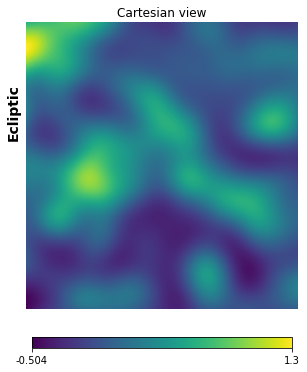

In [10]:
od_map_smooth = read_amp_map("/mnt/raid-cita/mlokken/data/number_density_maps/3_zbins_grf_comparison/redmagic_highdens_zbin2_od_map_nosmooth_AMPLITUDE_fwhm28a.fits")
od_map_flat   = hp.cartview(od_map_smooth, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E')

In [49]:
od_map = read_amp_map("/mnt/raid-cita/mlokken/data/number_density_maps/3_zbins_grf_comparison/redmagic_highdens_zbin2_od_map_nosmooth_AMPLITUDE_fwhm0a.fits")
od_map_orig = hp.read_map("/mnt/raid-cita/mlokken/data/number_density_maps/3_zbins_grf_comparison/redmagic_highdens_zbin2_od_map_nosmooth.fits")

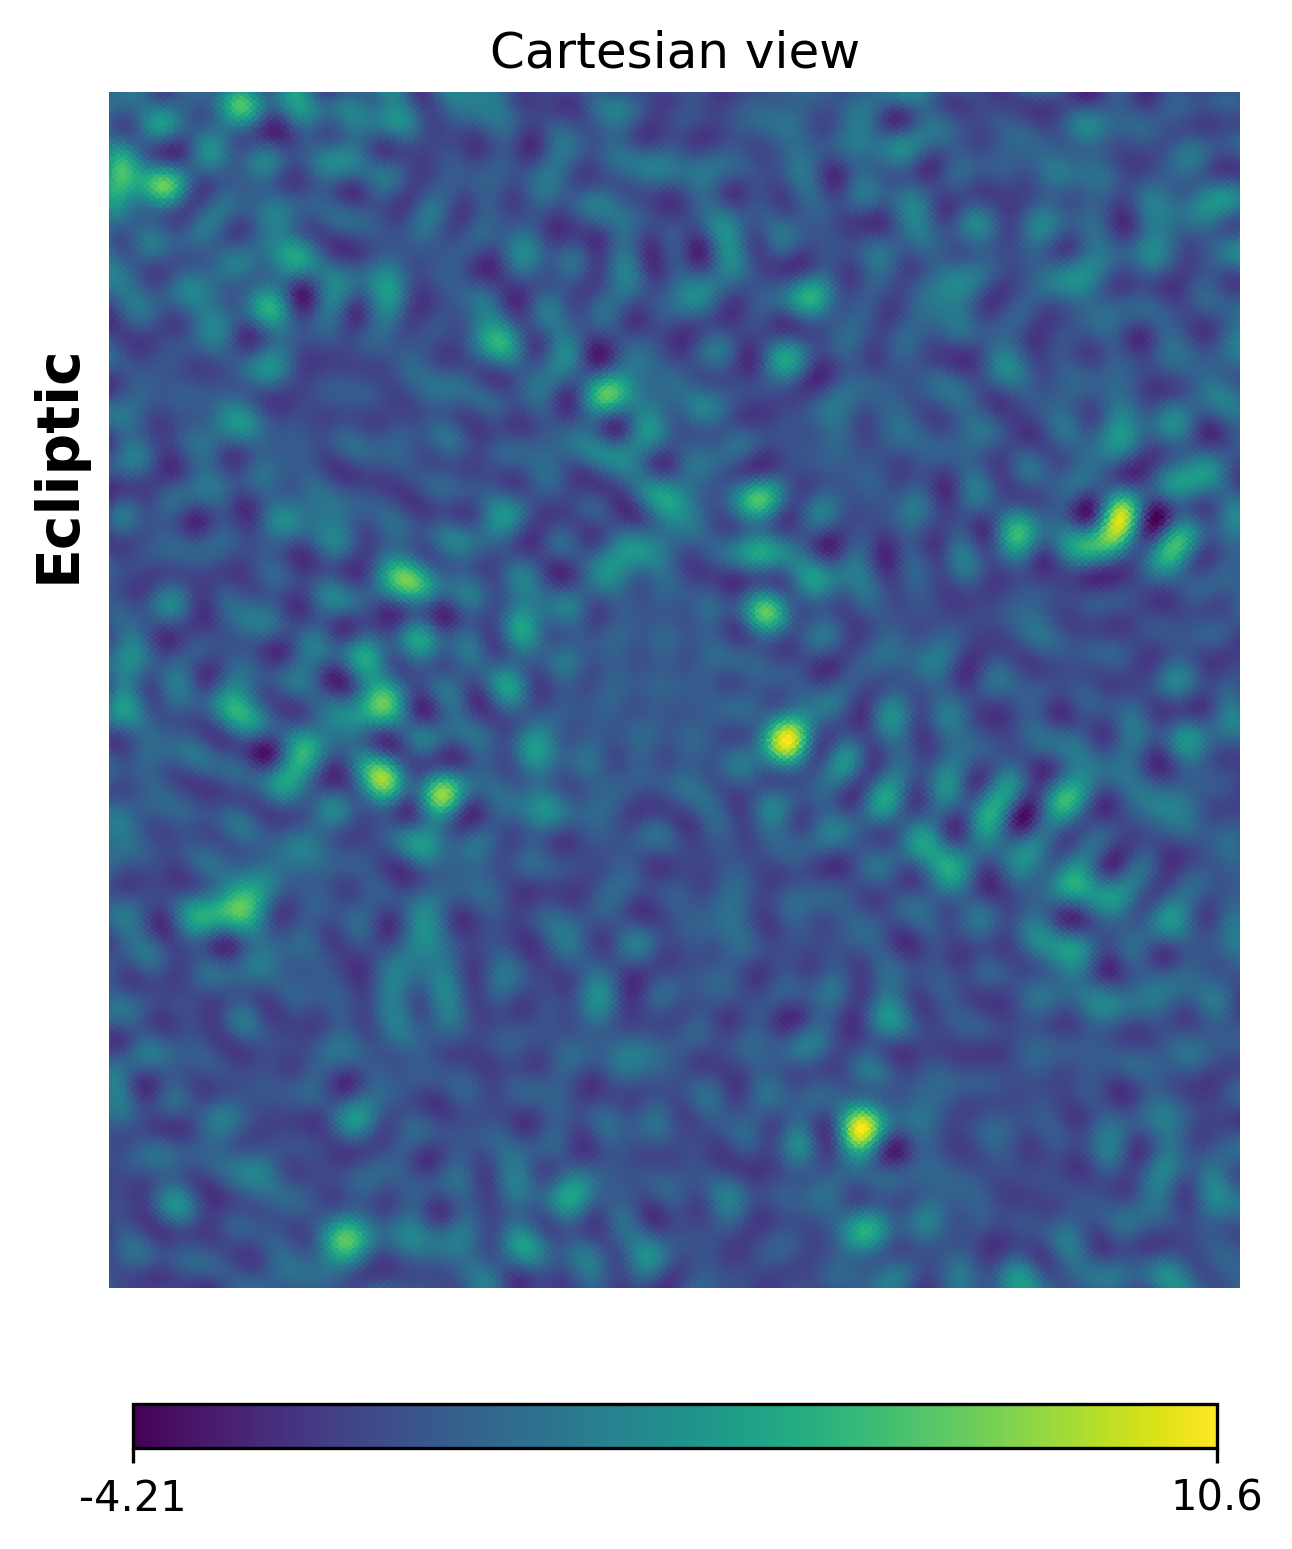

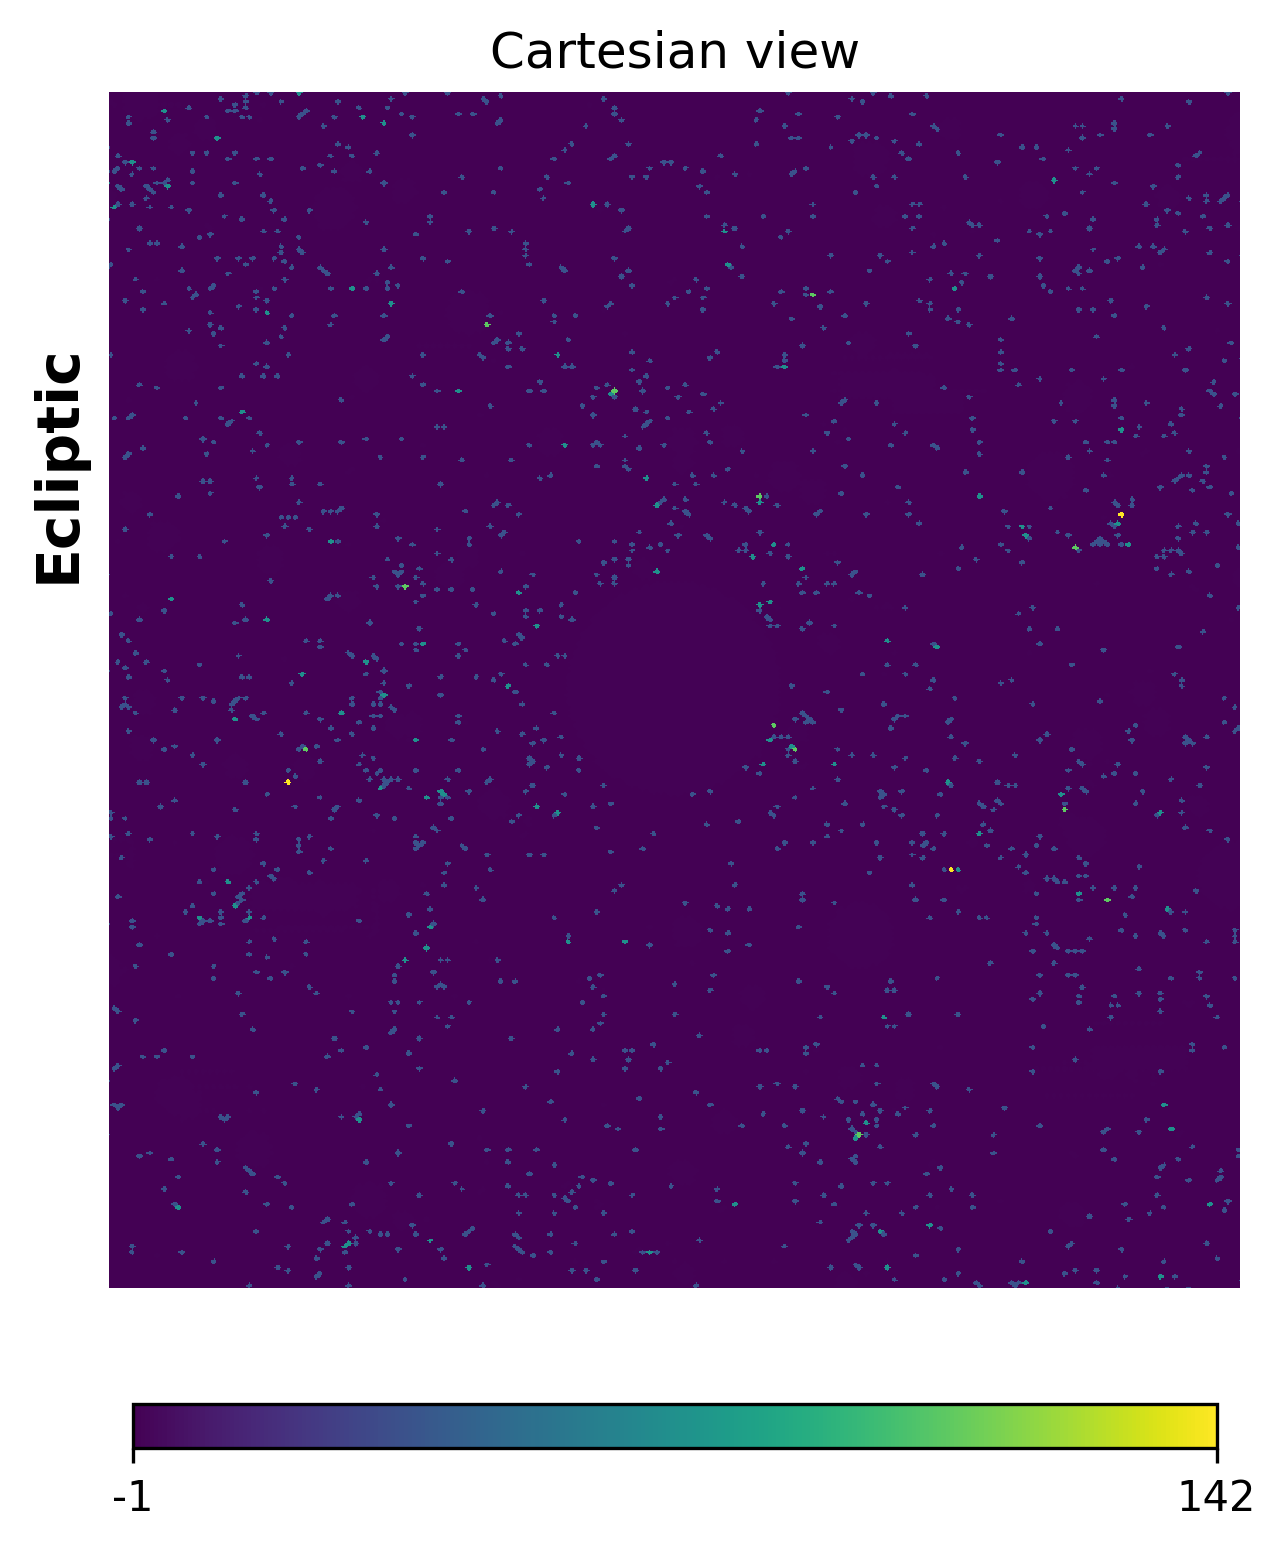

In [50]:
od_map_coop_flat = hp.cartview(od_map, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E')
od_map_orig_flat = hp.cartview(od_map_orig, latra=[latmin,latmax], lonra=[lonmin,lonmax], return_projected_map=True, coord='E')

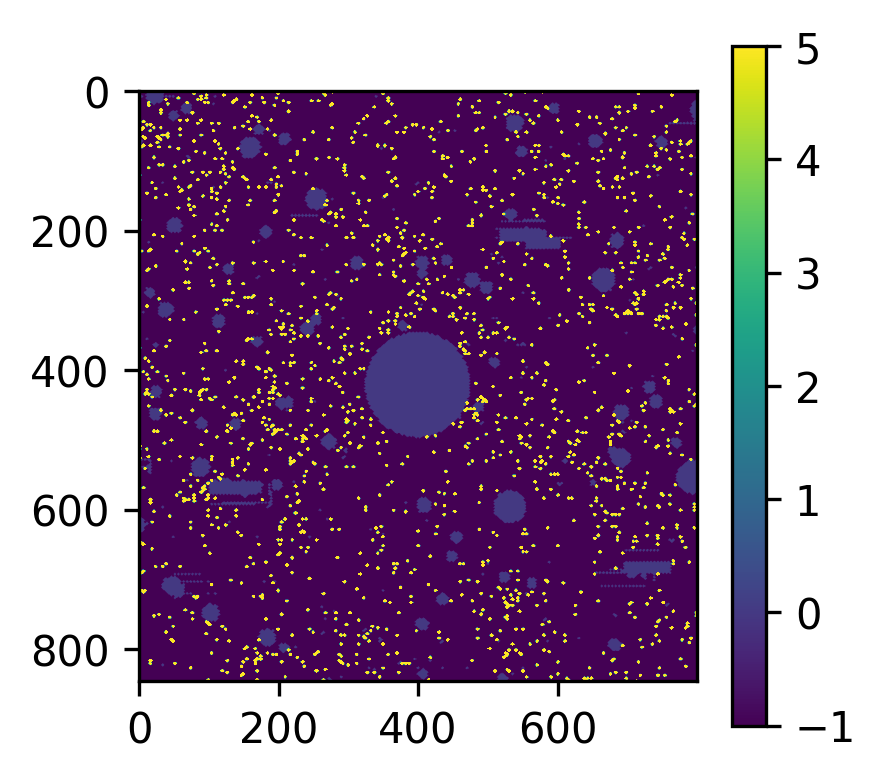

In [53]:
plt.figure(figsize=[3,3])
plt.imshow(od_map_orig_flat[::-1], vmax=5)
plt.colorbar()

In [11]:
(cosmo.kpc_comoving_per_arcmin(mid).to(u.megaparsec/u.arcmin)).to(u.megaparsec/u.deg)*(lonmax-lonmin)*u.deg

<Quantity 102.7169897 Mpc>

In [12]:
w = wcs.WCS(naxis=2)

height = float(od_map_flat.shape[0])
length = float(od_map_flat.shape[1])
w = wcs.WCS(naxis=2)
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.


w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]

[400. 423.]
[13.25 -1.15]
[-0.004375    0.00437352]


In [13]:
# selected points
# Xpix,Ypix = w.all_world2pix(allz_peaks_info[0][:,1][nu_sel],allz_peaks_info[0][:,2][nu_sel],0)
# Xpix_e, Ypix_e = w.all_world2pix(allz_peaks_info[0][:,1][e_sel],allz_peaks_info[0][:,2][e_sel],0)

# all except the very large e
nu_sel = nu_vals>0.5
e_sel  = e_vals<0.5
sel_area  = (allz_peaks_info[0][:,1]>lonmin)&(allz_peaks_info[0][:,1]<lonmax)&(allz_peaks_info[0][:,2]>latmin)&(allz_peaks_info[0][:,2]<latmax)
selection = nu_sel&sel_area&e_sel
Xpix,Ypix = w.all_world2pix(allz_peaks_info[0][:,1][selection],allz_peaks_info[0][:,2][selection],0)
U_arr, V_arr = get_vector_components(allz_peaks_info[0][:,0][selection])

print(len(Xpix))

17


In [23]:
# figure out size of circle
fwhm=int((28/60)/(lonmax-lonmin)*od_map_flat.shape[0])

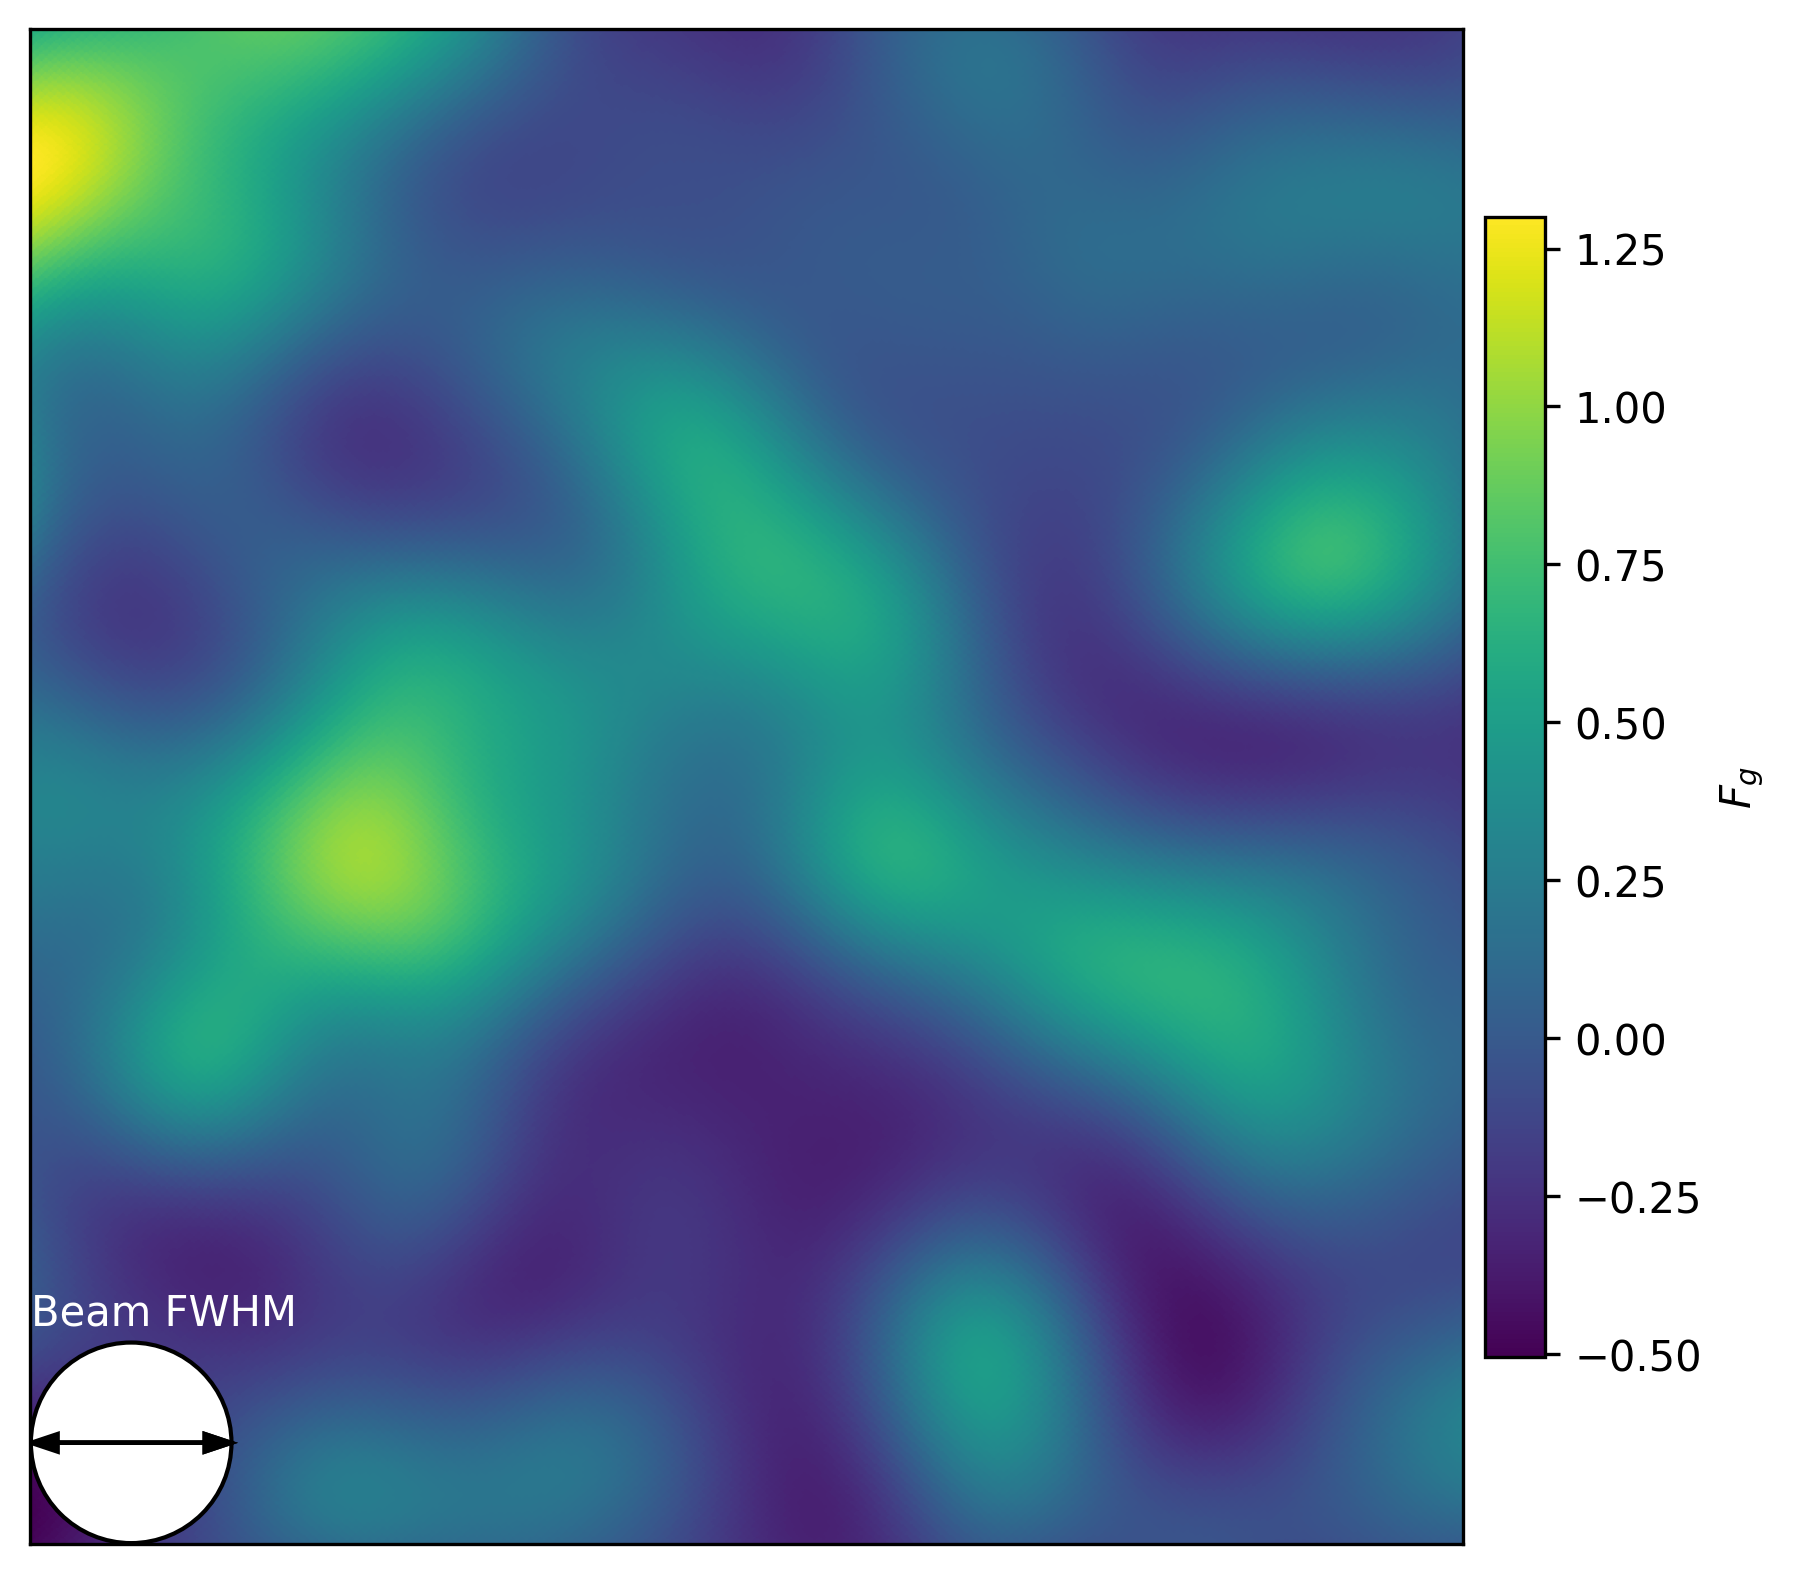

In [35]:
# Make the figure

fig = plt.figure(figsize=(10,10))

mpl.rcParams['figure.dpi'] = 300

nrows = 2
ax1 = plt.subplot(1, 2, 1, projection=w)
# ax2 = plt.subplot(1, 2, 2, projection=w)

ax1.set_xticks([])
ax1.set_xticklabels([])

dmap = ax1.imshow(od_map_flat)

mpl.rcParams['contour.negative_linestyle'] = 'solid'

s_e   = 5*e_vals[selection]**2
s_nu  = 10*nu_vals[selection]**3
# plt.colorbar(sc1, cax=ax1)

ax1.set_xlabel("RA")
ax1.set_ylabel("Dec")


# Make the figure


# ax1.contour(od_map_flat, colors='royalblue', zorder=1)
indices = np.arange(len(Xpix))
indices = np.delete(indices,[1,3,8,10,11,12,13,14])
# sc1 = ax1.scatter(Xpix[indices],Ypix[indices], linewidths=1, s=s_nu[indices], edgecolors='k', facecolor='None', zorder=1)

# ax1.quiver(Xpix[indices],Ypix[indices], -U_arr[indices], V_arr[indices], width=0.007, color = 'k', scale_units = 'inches', scale = 1/e_vals[selection][indices], zorder=2)
# qv = ax1.quiver(Xpix[indices],Ypix[indices], U_arr[indices], -V_arr[indices], width=0.007, color = 'k', scale = 1/e_vals[selection][indices], scale_units = 'inches', zorder=3)
# ax1.scatter(Xpix[indices],Ypix[indices], linewidths=1, s=1, c='w', zorder=4)

lon = ax1.coords[0]
lat = ax1.coords[1]

# ax1.text(.19,.54,"e=0.15", transform=ax1.transAxes, rotation=85, fontdict=fd)
# ax1.text(.8,.32,"e=0.44", transform=ax1.transAxes, rotation=314)

plt.text(0,fwhm+10, "Beam FWHM", fontsize=10, color='w')
circ = plt.Circle((fwhm/2,fwhm/2), fwhm/2, edgecolor='k', facecolor='w')
ax1.add_patch(circ)
arr  = plt.arrow(0,fwhm/2,fwhm,0, color='k', length_includes_head=True, head_width=10)
arr2 = plt.arrow(fwhm,fwhm/2,-fwhm,0, color='k', length_includes_head=True, head_width=10)
ax1.add_patch(arr)

lon.set_ticks_visible(False)
lon.set_ticklabel_visible(False)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)

cbar_ax = fig.add_axes([0.5, 0.31, 0.02, 0.38])
cb = plt.colorbar(dmap, ax=ax1, cax=cbar_ax)
cb.set_label("$F_g$")


  
plt.tight_layout()
# plt.savefig("/home/mlokken/oriented_stacking/plots/paper1/vis/nu_e_vis.png")

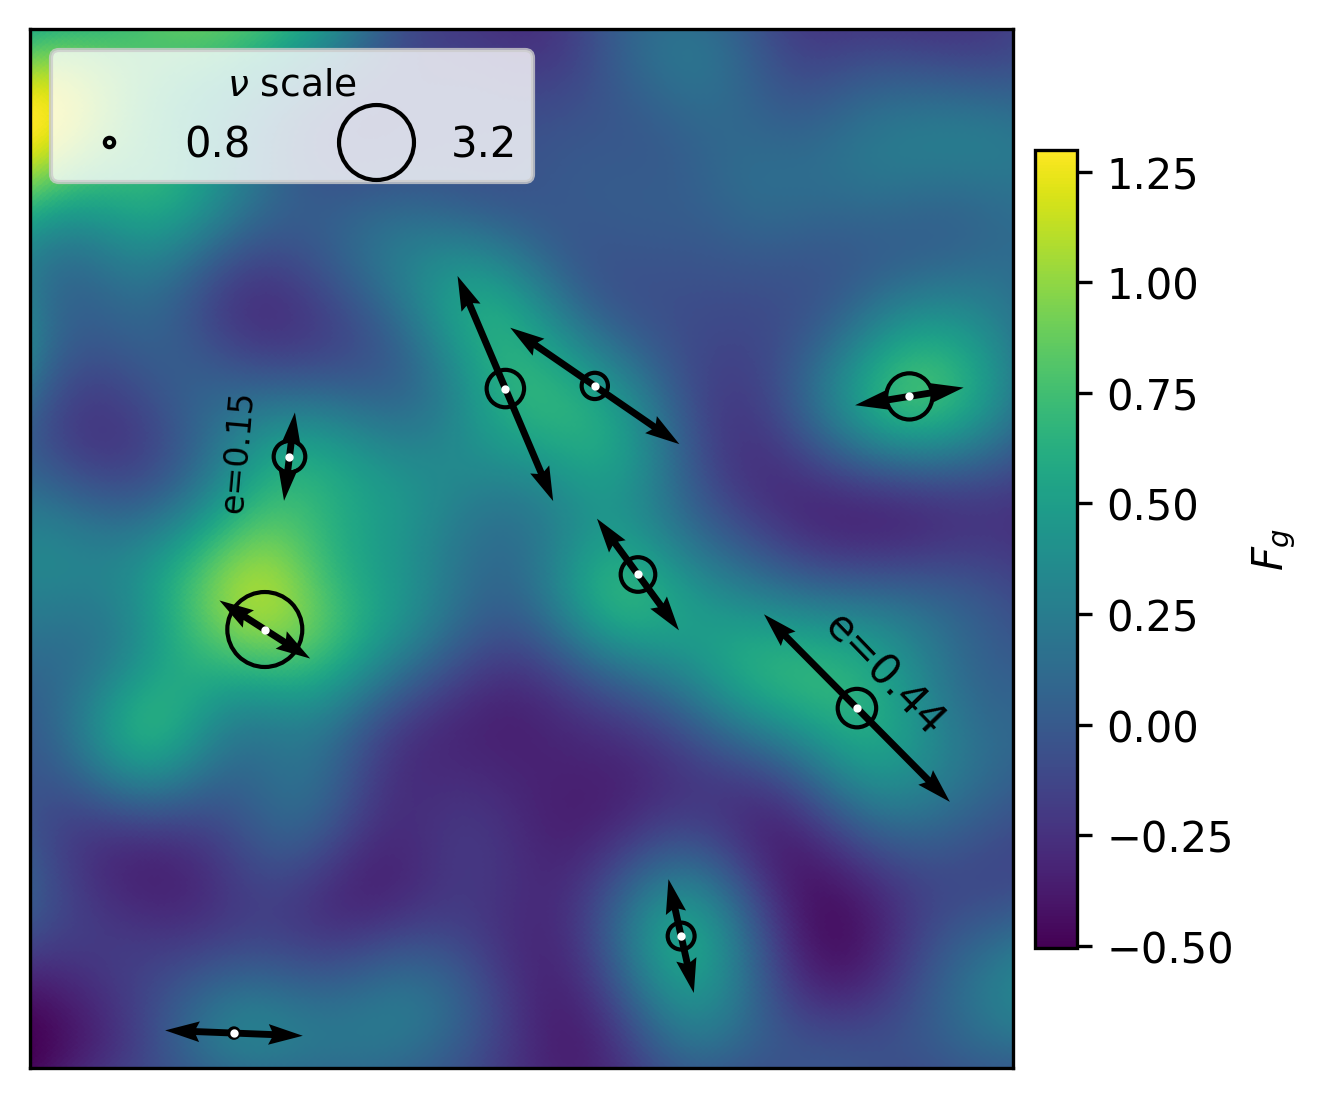

In [103]:
# Make the figure

fig = plt.figure(figsize=(7,7))

mpl.rcParams['figure.dpi'] = 300

nrows = 2
ax1 = plt.subplot(1, 2, 1, projection=w)
# ax2 = plt.subplot(1, 2, 2, projection=w)

ax1.set_xticks([])
ax1.set_xticklabels([])

dmap = ax1.imshow(od_map_flat)

mpl.rcParams['contour.negative_linestyle'] = 'solid'

s_e   = 5*e_vals[selection]**2
s_nu  = 10*nu_vals[selection]**3
# plt.colorbar(sc1, cax=ax1)

ax1.set_xlabel("RA")
ax1.set_ylabel("Dec")


# Make the figure


# ax1.contour(od_map_flat, colors='royalblue', zorder=1)
indices = np.arange(len(Xpix))
indices = np.delete(indices,[1,3,8,10,11,12,13,14])
sc1 = ax1.scatter(Xpix[indices],Ypix[indices], linewidths=1, s=s_nu[indices], edgecolors='k', facecolor='None', zorder=1)

ax1.quiver(Xpix[indices],Ypix[indices], -U_arr[indices], V_arr[indices], width=0.007, color = 'k', scale_units = 'inches', scale = 1/e_vals[selection][indices], zorder=2)
qv = ax1.quiver(Xpix[indices],Ypix[indices], U_arr[indices], -V_arr[indices], width=0.007, color = 'k', scale = 1/e_vals[selection][indices], scale_units = 'inches', zorder=3)
ax1.scatter(Xpix[indices],Ypix[indices], linewidths=1, s=1, c='w', zorder=4)

lon = ax1.coords[0]
lat = ax1.coords[1]


# produce a legend with a cross section of sizes from the scatter
handles, labels = sc1.legend_elements(prop="sizes", alpha=0.6)
label_flt = [(float(l.split('{')[1][:-2])/10)**(1/3) for l in labels]
where_max = np.where(np.asarray(label_flt)==max(label_flt))[0][0]
where_min = np.where(np.asarray(label_flt)==min(label_flt))[0][0]
labels = np.asarray(["%.1f"%flt for flt in label_flt])
handles = np.asarray(handles)

fd = {"size":8}
for handle in handles:
    handle.set(fillstyle="none", color='k', alpha=1)
legend1 = ax1.legend(handles[[where_min,where_max]], labels[[where_min,where_max]], loc="upper left", ncol=2, title=r"$\nu$ scale", prop={'size': 10})
plt.setp(legend1.get_title(),fontsize=9)


ax1.text(.19,.54,"e=0.15", transform=ax1.transAxes, rotation=85, fontdict=fd)
ax1.text(.8,.32,"e=0.44", transform=ax1.transAxes, rotation=314)



lon.set_ticks_visible(False)
lon.set_ticklabel_visible(False)
lat.set_ticks_visible(False)
lat.set_ticklabel_visible(False)

cbar_ax = fig.add_axes([0.5, 0.31, 0.02, 0.38])
cb = plt.colorbar(dmap, ax=ax1, cax=cbar_ax)
cb.set_label("$F_g$")


  
plt.tight_layout()
plt.savefig("/home/mlokken/oriented_stacking/plots/paper1/vis/nu_e_vis.png")

In [15]:
where_max[0][0]

IndexError: invalid index to scalar variable.

In [125]:
for l in labels:
    print((float(l.split('{')[1][:-2])/10)**(1/3))

0.7937005259840998
1.5847509618114424
1.6108635723093283
1.7925618986228657
1.9037782619633032
2.0066445670841784
2.0432257053988057
2.3077245009753895
2.7107935567224892


In [126]:
[(float(l.split('{')[1][:-2])/10)**(1/3) for l in labels]

[0.7937005259840998,
 1.5847509618114424,
 1.6108635723093283,
 1.7925618986228657,
 1.9037782619633032,
 2.0066445670841784,
 2.0432257053988057,
 2.3077245009753895,
 2.7107935567224892]

In [118]:
labels[0].split('{')[1][:-2]
labels[1].split('{')[1][:-2]
(float(labels[2].split('{')[1][:-2])/10)**(1/3)

1.6108635723093283

In [ ]:
for 